<h1>Electron Spectrometer 2D Simulation</h1>
<h3>Uses given magnetic fields to determine electron trajectories for various energies. Compares the results to an analytical expression that assumes a uniform magnetic field. The basic setup is given in the image below. The coordinate system used throughout this program is also defined here.</h3>

<img src="espec_basic.svg" />

<h2>Imports and Fundamental Constants</h2>
Import python packages and define commonly used physical constants

In [36]:
# Electron spectrometer 2D simulation code

#Imports
from math import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.interpolate
from scipy.stats import maxwell
import matplotlib.cbook as cbook
from scipy.optimize import curve_fit
import os

#Import custom modules
from physics import *

%matplotlib notebook

<h2>Program specific constants</h2>
Define and calculate constants used throughout this particular program. 

In [37]:
#Program specific constants
length = 3.0 #magnet and interaction length in inches
width = 0.6 #interaction width in inches
magwidth = 2.0 #magnet width in inches
magsep = 0.125 #magnet separation in inches
pinholediameter = 500 #pinhole diameter in um
numbins = 300 #number of bins
KEmin = 60 #minimum desired electron KE to be detected in keV
KEmax = 4000 #maximum desired electron KE to be detected in keV

#Conversion to base units
length = length*0.0254
width = width*0.0254
magwidth = magwidth*0.0254
magsep = magsep*0.0254
pinholediameter = pinholediameter*10**-6
KEmin = KEmin*1000*q
KEmax = KEmax*1000*q

#Calculated constants
binwidth = length/numbins #screen bin width
yf = width #final x-position when at screen
B0 = 2*me*c/(q*yf)*sqrt((KEmin/(me*c**2)+1)**2-1) #maximum magnetic field (in T) required to detect electrons with KE=KEmin
##B0 = 2*me*c*yf/(q*(length**2+yf**2))*sqrt((KEmax/(me*c**2)+1)**2-1) # miniumum magnetic field (in T) required to detect electrons with KE=KEmax
B0 = 50./1000
print("magnetic field =",B0*1000,"mT")

magnetic field = 50.0 mT


<h2>Define Functions</h2>
Here we define the analytical expressions. These have been derived assuming a uniform magnetic field and relativistic electrons. The radius of the electron trajectory in this case is given by

$$ r = \frac{m_e c}{e B_0} \sqrt{ \left( \frac{E}{m_e c^2} + 1 \right)^2 - 1 }$$

where $B_0$ is the magnetic field strength and $E$ is the electron energy. In the simplest case, the detector is placed at the edge of the magnet. The final electron position along the detector as a function of energy is then given by

$$ z = \sqrt{ r^2 - (y-r)^2)} $$

where y is the distance from the edge of the detector that the electron is injected.

In [38]:
#Defined analytic functions
def KEcalc(z,y):
    """Returns KE in J given z-position in m"""
    return me*c**2*(sqrt((q*B0/(me*c))**2*((z**2+y**2)/(2*y))**2+1)-1)

def Radius(KE):
    """Returns radius of electron orbit in m given KE in keV"""
    return me*c/(q*B0)*sqrt((KE*1000*q/(me*c**2)+1)**2-1)

def zfcalc(KE,y):
    """Returns the z-position at the screen in inches given the KE in keV and the distance between the 
    electron injection position and the screen (y) in m"""
    R = Radius(KE)
    return sqrt(R**2 - (y-R)**2)

#Above functions were generalized for a screen standing off of the magnets by some distance 
def zfcalcGeneral(KE,yM,y):
    """Returns the z-position at the screen in inches given the KE in keV, and the distance between the 
    electron injection position and the screen (y) in m, and the magnet edge y-position yM in m"""
    R = Radius(KE)
    zM = zfcalc(KE,yM) #Final z-position of the electrons once they reach the magnet edge
    return zM + (y - yM)*(R - yM)/zM

def KEcalcGeneral(zf,yM,yf):
    """Returns KE in J given z-position of electrons, y-position of magnet edge, and y-position of screen, all in m"""
    a = (yM+yf)**2
    b = -2*yM*(yf*(yM+yf)+zf**2)
    d = yM**2*(zf**2+yf**2)
    f = (me*c)/(q*B0)
    g = (-b+sqrt(b**2-4*a*d))/(2*a)
    return me*c**2*(sqrt(g**2+f**2)/f - 1)

def AngleIncidence(KE,yM):
    """Returns the angle at which the electrons are incident on the screen"""
    R = Radius(KE)
    return asin((R-yM)/R)

## Numerical Simulation with uniform magnetic field in 2D (relativistic)

<IPython.core.display.Javascript object>


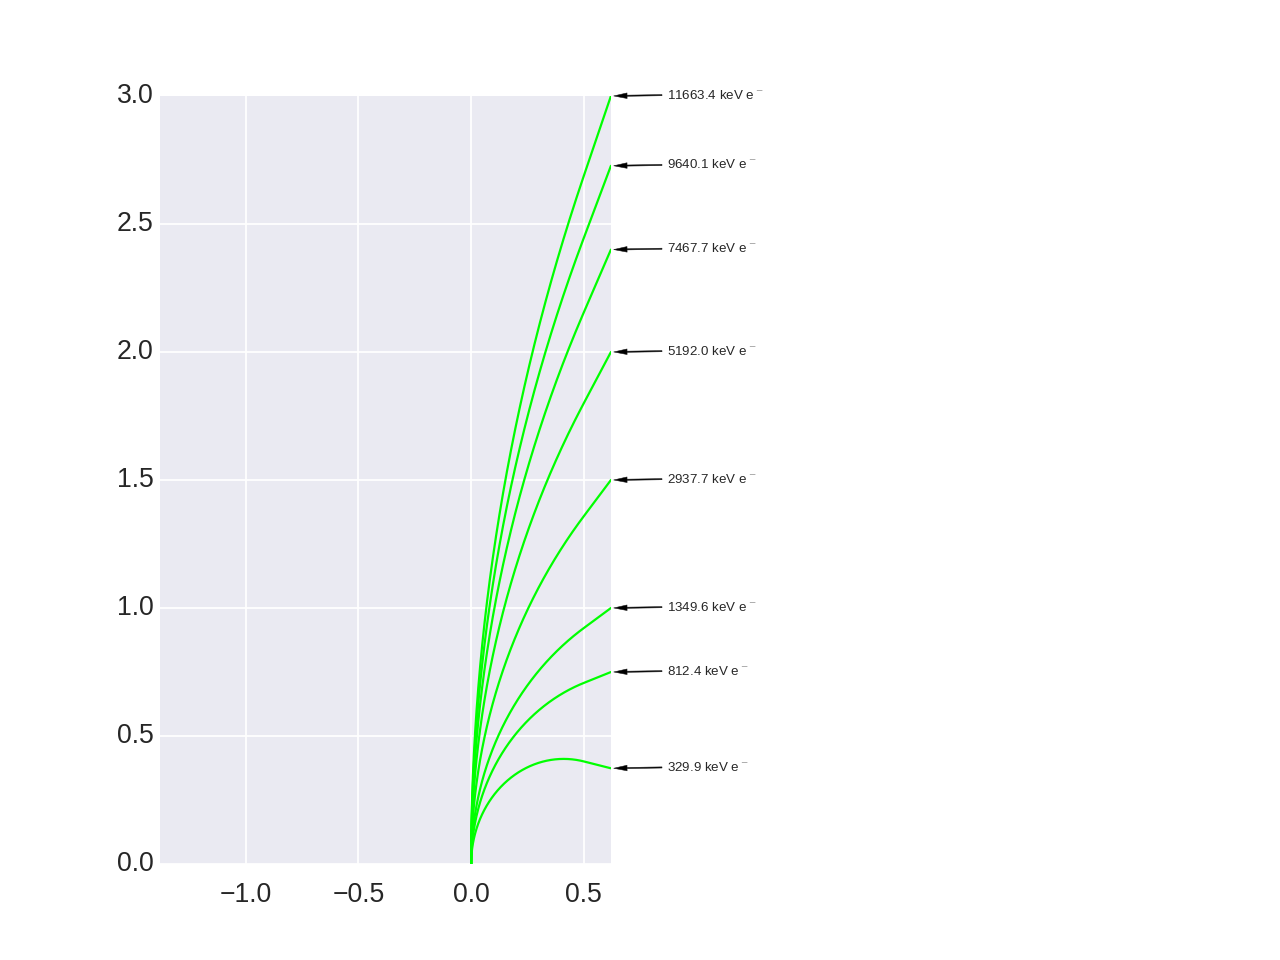

KE (keV) 	 Simulation z-position (in) 	 Theory z-position (in) 	 Incident Angle (degrees)
329.9 	 	 0.37382 	 	 	 0.373957 	 	 -12.584898 	 	 -12.578099
812.4 	 	 0.74989 	 	 	 0.74998 	 	 19.496766 	 	 19.500121
1349.6 	 	 0.999948 	 	 	 0.999999 	 	 33.054324 	 	 33.053473
2937.7 	 	 1.499943 	 	 	 1.499999 	 	 49.60056 	 	 49.600949
5192.0 	 	 1.999966 	 	 	 1.999995 	 	 58.961872 	 	 58.961402
7467.7 	 	 2.399952 	 	 	 2.399997 	 	 63.878606 	 	 63.878187
9640.1 	 	 2.727261 	 	 	 2.727272 	 	 66.894101 	 	 66.894189
11663.4 	 	 3.000025 	 	 	 3.000003 	 	 68.92981 	 	 68.929581


In [39]:
#Create Figure
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121)

#Input constants
B0 = 2136.0 #Magnetic field strength in Gauss
B0 = B0/10**4
yM = 0.5 #edge of magnet relative to slit in inches
yf = yM+0.12 #screen position relative to slit in inches
length = 3.0 #magnet and interaction length in inches
width = 0.5 #interaction width in inches
magwidth = 2.0 #magnet width in inches
magsep = 0.125 #magnet separation in inches

#Conversion to base units
yf = yf*.0254
yM = yM*.0254
length = length*0.0254
width = width*0.0254
magwidth = magwidth*0.0254
magsep = magsep*0.0254

#Electron kinetic energy in keV
KE = [round(KEcalcGeneral(9.5*10**-3,yM,yf)/(1000*q),1),round(KEcalcGeneral(length/4,yM,yf)/(1000*q),1),\
      round(KEcalcGeneral(length/3,yM,yf)/(1000*q),1),round(KEcalcGeneral(length/2,yM,yf)/(1000*q),1),\
      round(KEcalcGeneral(length/1.5,yM,yf)/(1000*q),1),round(KEcalcGeneral(length/1.25,yM,yf)/(1000*q),1),\
      round(KEcalcGeneral(length/1.1,yM,yf)/(1000*q),1),round(KEcalcGeneral(length,yM,yf)/(1000*q),1)] 

for i in range(len(KE)):   

    #Initial conditions
    KE[i] = KE[i]*1000*q #Convert to J
    v = [0,0,c*sqrt(1-(1/(KE[i]/(me*c**2)+1))**2)] #initial velocity
    gamma = 1/sqrt(1-v[2]**2/c**2)
    p = [0,0,gamma*me*v[2]] #initial momentum
    r = [0,0,0] #initial position
    dt = 10**-14 #time step in s
    
    ypos = []
    zpos = []
    while r[1]<yf:
        #update magnetic field
        if r[1]<=yM:
            B = B0
        else:
            B = 0
            
        #update velocity (since the magnetic field does no work, |v| and gamma are constant)
        v[1] += q*v[2]*B/(me*gamma)*dt
        v[2] += -q*v[1]*B/(me*gamma)*dt
        
        #update position:
        r[1] += v[1]*dt
        r[2] += v[2]*dt

        #record position:
        ypos.append(r[1]/.0254)
        zpos.append(r[2]/.0254)
        
        #prevent infinite loop if electrons never reach screen:
        if r[1]<0:
            break
    
    if i==0:
        print('KE (keV)','\t','Simulation z-position (in)','\t','Theory z-position (in)','\t','Incident Angle (degrees)')
        
    if r[1]<0:
        print(KE[i]/(1000*q),'keV electrons never reach the detector')
    else:
        plt.plot(ypos,zpos,linewidth=2,color=[0,1,0])
        plt.xlim(yf/0.0254-magwidth/0.0254,yf/.0254)
        plt.ylim(0,length/.0254)
        annotation = '{KE} keV e$^-$'.format(KE=str(KE[i]/(1000*q)))
        ax.annotate(annotation, xy=(yf/.0254, r[2]/.0254), xytext=(yf/.0254+0.25, r[2]/.0254-0.01),\
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.0, headwidth=5.0))
        print(KE[i]/(1000*q),'\t \t',round(r[2]/.0254,6),'\t \t \t',round(zfcalcGeneral(KE[i]/(1000*q),yM,yf)/0.0254,6),\
        '\t \t',round(atan(v[2]/v[1])*360/(2*pi),6), '\t \t', round(AngleIncidence(KE[i]/(1000*q),yM)*360/(2*pi),6))

## Load and plot magnetic field

<IPython.core.display.Javascript object>


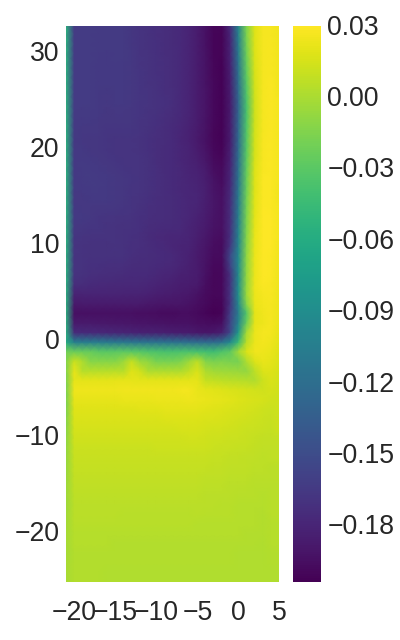

In [48]:
#Set tick padding
mpl.rcParams['xtick.major.pad'] = 16
mpl.rcParams['ytick.major.pad'] = 6

especFolderPath = os.curdir + '/Magnetic_Fields'

RadiaFieldPath = especFolderPath + '/3Dmagnetostaticespecdata.csv'
fname = cbook.get_sample_data(RadiaFieldPath, asfileobj=False)

# FakeFieldPath = especFolderPath + '/measuredfakefull_Bx.csv'
# FakeFieldycoordPath = especFolderPath + '/measuredfakefull_ycoord.csv'
# FakeFieldzcoordPath = especFolderPath + '/measuredfakefull_zcoord.csv'

RealFieldPath = especFolderPath + '/march7fields_Bx.csv'
RealFieldycoordPath = especFolderPath + '/march7fields_ycoord.csv'
RealFieldzcoordPath = especFolderPath + '/march7fields_zcoord.csv'

# Bx = np.matrix.transpose(np.loadtxt(open(FakeFieldPath, "rb"), delimiter=","))
# Bx = np.multiply(Bx, 0.1)
# Y = np.matrix.transpose(np.loadtxt(open(FakeFieldycoordPath, "rb"), delimiter=","))
# Z = np.matrix.transpose(np.loadtxt(open(FakeFieldzcoordPath, "rb"), delimiter=","))

Bx = np.loadtxt(open(RealFieldPath, "rb"), delimiter=",")
Bx = np.multiply(Bx, 10**-3)
Y = np.loadtxt(open(RealFieldycoordPath, "rb"), delimiter=",")
Z = np.loadtxt(open(RealFieldzcoordPath, "rb"), delimiter=",")

Ny = len(Bx)
Nz = len(Bx[0])

#Convert 1D radia array to 3D array
# Bx1DArray = np.genfromtxt(fname,delimiter=",",usecols=(5))
# By1DArray = np.genfromtxt(fname,delimiter=",",usecols=(3))
# Bz1DArray = np.genfromtxt(fname,delimiter=",",usecols=(4))
# Nx = 3 #Number of divisions along specified dimension
# Ny = 61
# Nz = 87
# Bx = np.zeros((Nx,Ny,Nz)) 
# By = np.zeros((Nx,Ny,Nz))
# Bz = np.zeros((Nx,Ny,Nz))
# X = range(Nx)
# Y = range(Ny)
# Z = range(Nz)
# Y, Z = np.meshgrid(Z, Y)
# for i in range(Nx):
#     for j in range(Ny):
#         for k in range(Nz):
#             Bx[i][j][k] = Bx1DArray[k+j*Nz+i*Ny*Nz]
#             By[i][j][k] = By1DArray[k+j*Nz+i*Ny*Nz]
#             Bz[i][j][k] = Bz1DArray[k+j*Nz+i*Ny*Nz]


#Plot
fig = plt.figure(figsize=(5,8))
#plt.imshow(Bx,cmap='viridis')
plt.pcolormesh(Y,Z,Bx,cmap='viridis',shading='gouraud')
plt.xlim(np.min(Y),np.max(Y))
plt.ylim(np.min(Z),np.max(Z))
plt.colorbar()
plt.tight_layout()
# ax = fig.add_subplot(111, projection='3d')
# field = ax.plot_surface(Y,Z,Bx,rstride=1, cstride=1, cmap='viridis')
# fig.colorbar(field, shrink=0.7, aspect=10)

## Magnetic field interpolation

In [41]:
#2D interpolation
y00 = Y[0,0]*10**-3
z00 = Z[0,0]*10**-3
deltay = 1.0*10**-3
deltaz = 1.0*10**-3
SimSizey = (Ny-1)*deltay
SimSizez = (Nz-1)*deltaz
def Binterp2D(y,z):
    """Uses bilinear interpolation to determine magnetic field at any given point in space (see wikipedia)"""
    #Lattice points below (x,y,z). Here n refers to the index and (x0,y0,z0) to the physical position:
    ny0 = int(floor((y-y00)/deltay))
    nz0 = int(floor((z-z00)/deltaz))
    y0 = y00 + ny0*deltay
    z0 = z00 + nz0*deltaz
    #Lattice points above (x,y,z). Here n refers to the index and (x1,y1,z1) to the physical position:
    ny1 = int(ceil((y-y00)/deltay))
    nz1 = int(ceil((z-z00)/deltaz))
    y1 = y00 + ny1*deltay
    z1 = z00 + nz1*deltaz
    return 1/((y1-y0)*(z1-z0))*(Bx[ny0][nz0]*(y1-y)*(z1-z) + Bx[ny1][nz0]*(y-y0)*(z1-z)\
                                + Bx[ny0][nz1]*(y1-y)*(z-z0) + Bx[ny1][nz1]*(y-y0)*(z-z0))

## Numerical simulation with measured magnetic field in 2D (relativistic)

In [42]:
#Input constants
B0 = 2136.0 #Magnetic field strength in Gauss
r0 = [0,-12.7,-12.7] #initial position in mm
yM = 0.5 #magnet edge position in inches
CCDpos = 3.02 #CCD y-position relative to magnet edge in mm
length = 3.0 #magnet and interaction length in inches
width = 0.5 #interaction width in inches
magwidth = 2.0 #magnet width in inches
magsep = 0.125 #magnet separation in inches

#Conversion to base units
B0 = B0/10**4
yM = yM*.0254
length = length*0.0254
width = width*0.0254
magwidth = magwidth*0.0254
magsep = magsep*0.0254
r0 = np.multiply(r0,10**-3)
CCDpos = CCDpos*10**-3

#Create Figures
# fig1 = plt.figure(figsize=(16,16.4))
# ax1 = fig1.add_subplot(121)
# fig2 = plt.figure(figsize=(8,8))
# ax2 = fig2.add_subplot(111)

#Main Program (older code, should be vectorized)
yf = yM + CCDpos #Screen position
# KE = [225.0, 500.0, 1000.0, 1570.0, round(KEcalcGeneral((1500*8+9500)*10**-6,yM,yf)/(1000*q),1), \
#       round(KEcalcGeneral((2200*8+9500)*10**-6,yM,yf)/(1000*q),1)] #Electron kinetic energy in keV
# KE = [200.0, 500.0, 1000.0, 1700.0]
KE = np.arange(200.0,1710.0,10)
zfinal = []
zfinalTheory = []
Angle = []
AngleSim = []
arclengthArray = [] #arclength of trajectory
for i in range(len(KE)):   

    #Initial conditions
    KE[i] = KE[i]*1000*q #Convert to J
    v = [0,0,c*sqrt(1-(1/(KE[i]/(me*c**2)+1))**2)] #initial velocity
    gamma = 1/sqrt(1-v[2]**2/c**2)
    p = [0,0,gamma*me*v[2]] #initial momentum
    r = np.copy(r0) #initial position
    dt = 10**-13 #time step in s
    
    ypos = []
    zpos = []
    Barray = []
    tarray = []
    t = 0 #initial time
    arclength = 0 #arclength of trajectory
    while r[1]<CCDpos:
        
        #if the electrons take more than a nanosecond, something wicked occurred
        if t>10*10**-9:
            break
        
        if r[1]==r0[1]:
            B = Bx[r0[1]*10**3,r0[2]*10**3]
        else:
            B = Binterp2D(r[1],r[2])
        
        #update velocity (since the magnetic field does no work, |v| and gamma are constant)
        v[1] += -q*v[2]*B/(me*gamma)*dt
        v[2] += q*v[1]*B/(me*gamma)*dt

        #update position:
        yold = r[1]
        zold = r[2]
        r[1] += v[1]*dt
        r[2] += v[2]*dt
        arclength += sqrt((r[1]-yold)**2+(r[2]-zold)**2)

        #record position:
        ypos.append(r[1]*10**3)
        zpos.append(r[2]*10**3)
        
        #record magnetic field:
        Barray.append(B*10**3)
        
        #record time:
        tarray.append(t*10**12)
        
        #prevent infinite loop if electrons never reach screen:
        if r[2]>33*10**-3:
            break
            
        #increment time 
        t+=dt
    
    arclengthArray.append(arclength)
#     if i==0:
#         print('KE (keV)','\t','Simulation z-position (mm)','\t','Theory z-position (mm)','\t','Incident Angle (degrees)')
        
#     if r[2]>40*10**-3:
#         print(KE[i]/(1000*q),'keV electrons never reach the detector')
#     else:
#         print(KE[i]/(1000*q),'\t \t',round(r[2]*10**3,6),'\t \t \t',\
#         round(zfcalcGeneral(KE[i]/(1000*q),-r0[1], -r0[1]+CCDpos)*10**3,6), '\t \t',\
#         round(atan(v[2]/v[1])*360/(2*pi),6), '\t \t', round(AngleIncidence(KE[i]/(1000*q),yM)*360/(2*pi),6),\
#         '\t \t', round(arclength,4)*10**2)
    
    zfinal.append(r[2]*10**3)
    zfinalTheory.append(zfcalcGeneral(KE[i]/(1000*q),-r0[1], -r0[1]+CCDpos)*10**3)
    Angle.append(AngleIncidence(KE[i]/(1000*q),yM))
    AngleSim.append(atan(v[2]/v[1]))
#     ax1.plot(ypos,zpos,linewidth=2,color=[0,1,0])
#     ax1.set_xlim(r0[1]*10**3-10,CCDpos*10**3)
#     ax1.set_ylim(r0[2]*10**3,40)
#     annotation = '{KE} keV e$^-$'.format(KE=str(KE[i]/(1000*q)))
#     ax1.annotate(annotation, xy=(CCDpos*10**3, r[2]*10**3), xytext=(CCDpos*10**3+5, r[2]*10**3+2),\
#                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.0, headwidth=5.0))

# ax1.set_xlabel('Position (mm)')
# ax1.set_ylabel('Position (mm)')
# ax2.plot(tarray,Barray,linewidth=2,color=[0,0,1])
# ax2.set_xlabel('Time (ps)')
# ax2.set_ylabel('Magnetic field (mT)')
# fig1.savefig('Trajectories.svg',bbox_inches='tight')

KESim = np.multiply(KE, 1/(1000*q))

/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [43]:
KE = np.arange(200.0,2000.0,10)
zfcalcGeneralVectorized = np.vectorize(zfcalcGeneral)
zfinalTheory = zfcalcGeneralVectorized(KE,-r0[1], -r0[1]+CCDpos)*10**3

In [44]:
i = -1
print(zfinalTheory[i])
zfinalTheoryPixels = np.multiply(np.subtract(zfinalTheory, 9.5), 1000/8.0)
print(zfinalTheoryPixels[i],KEcalcGeneral(np.multiply(zfinalTheory[i],10**-3),yM,yf)/(10**6*q))

31.1665092108
2708.31365135 1.99


In [45]:
# Arclength_vs_Energy = np.vstack((np.divide(KE,1000*q),np.multiply(arclengthArray,10**2)))
# np.savetxt('Arclength_vs_Energy.csv',np.transpose(Arclength_vs_Energy),delimiter=',')

## Plot kinetic energy vs. position

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


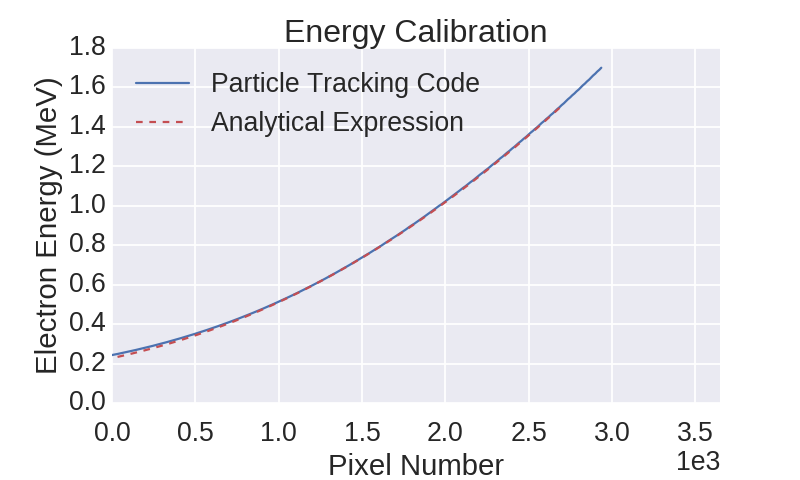

In [46]:
sns.set(context='poster',font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')

#Set tick padding
mpl.rcParams['xtick.major.pad'] = 16
mpl.rcParams['ytick.major.pad'] = 6

B0 = 1710*10**-4
zfinalPixels = np.multiply(np.subtract(zfinal, 9.5), 1000/8.0)
zfinalTheoryPixels = np.multiply(np.subtract(zfinalTheory, 9.5), 1000/8.0)
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(zfinalPixels,np.divide(KESim,1000),linewidth=2, color='b', label='Particle Tracking Code')
ax1.plot(zfinalTheoryPixels,KEcalcGeneral(np.multiply(zfinalTheory,10**-3),yM,yf)/(10**6*q)\
         ,linewidth=2, color='r', label='Analytical Expression',linestyle='--')
ax1.set_ylabel('Electron Energy (MeV)')
ax1.set_xlabel('Pixel Number')
ax1.set_xlim(0,3648)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc=2)
plt.title('Energy Calibration')
plt.subplots_adjust(left=0.14,bottom=0.16) #Adjust spacing to prevent clipping of x and y labels
#plt.savefig('Energy_Calibration.svg')
print()

In [47]:
KE = []
zposition = []
for i in linspace(0,66.7,10000):
    zposition.append(i+9.5)
    KE.append(KEcalcGeneral(np.multiply(i+9.5,10**-3),yM,yf)/(1000*q))

# np.savetxt("EvsZ.csv", KE, delimiter=",")
# np.savetxt("Z.csv", zposition, delimiter=",")
# np.savetxt("KE.csv", np.arange(250.0,1580.0,10), delimiter=",")
# np.savetxt("Angle.csv", Angle, delimiter=",")